# Lecture 09
## Speech Recognition


## Learning Objectives <a id="goal"></a>
We wil build a Simple Speech Recognition Engine using Convolutional Layers in Keras which will classified different sounds.
<br>- We will learn how to perform feature extraction (MFCC) and train the model
<br>- We will demonstrate that our model can recognize words.
<br>- Determine different words captured by the microphone (Test)   

We learned about CNNs, RNNs and classified MNIST for images dataset using Deep Learning libraries. We learned how to take an image and treat it as an array of numbers so that we can feed directly into a neural network for image recognition. Now we can do the same with speech recognition audio files!
<br>
### Sound is transmitted as waves. How do we turn sound waves into numbers? <a id="sound_to_waves"></a>
Speech recognition is complex and tricky so to keep everything simple we will start with a practical tutorial using word recognition and Kaggle datasets of number words.
<br>

### Data and Code
<br>Data used in the examples in this notebook are downloaded from https://storage.cloud.google.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz site. The directory into which we expanded collections of single spoken words: bird, dog, cat, four, happy,..., etc, we called `data`.
       <br> To reduce the processing time, we trained the neural network using a subset of data. You can do as you please. You can work with small or the entire data set.
        <br>Static images in this notebook should resided in directory named `images`. The content of the directory `images` is provide on the class site, week 09 folder.
<br> This code also uses file `preprocess.py` with several convenient functions which manipulate speach files and perform MFCC extraction.


# Various libraries we might or might not use

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fft import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

##  Where to look for the inspiration
<a id="wheretostart"></a>

<b>Speech recognition is a really big R&amp;D field and it is hard to get to know important things in short time!</b>

You can take many different approaches for solutions based on neural networks and architectures. Some of the most popular techniques are: Connectionist Temporal Classification (CTC) by using Recurrent Neural Network (RNN) in TensorFlow, Keras, Automatic Speech Recognition (ASR), Hidden Markov Model (HMM) based on ASR, Gaussian mixture models with HMMs, Deep models with HMMs, Large Vocabulary Continuous Speech Recognition Systems (LVCSR).

This tutorial focuses on two models and a very small vocabulary, with recordings with only one word in it, with a (mostly) given length:

1. Encoder-decoder: https://arxiv.org/abs/1508.01211
2. RNNs with CTC loss: https://arxiv.org/abs/1412.5567<br>

3. Classic speech recognition is described here: http://www.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/tutorial%20on%20hmm%20and%20applications.pdf

You can find *Kaldi* [Tutorial for dummies](http://kaldi-asr.org/doc/kaldi_for_dummies.html), with a problem similar to this.

Notebook code was adapted from the follwing sources:<br>
Tensorflow:<br>
https://www.tensorflow.org/tutorials/audio_recognition
https://github.com/ugnelis/tensorflow-rnn-ctc/blob/master/README.md
<br>
LibROSA:https://github.com/librosa/librosa/tree/main/docs/examples <br>
Kaggle / Data / Python code: <br>
https://github.com/pannous/tensorflow-speech-recognition
https://www.kaggle.com/davids1992/speech-representation-and-data-exploration/notebook
https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/download/train.7z
https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/download/test.7z

### Sampled Sound Data Processing
We now know how to generate an array of numbers which represent the sound wave’s amplitude at small intervals, e.g., 1/16.000 of a second.

We could feed these numbers right into a neural network. But trying to recognize speech patterns by processing these samples directly is difficult. Instead, we can make the problem easier by doing some pre-processing on the audio data.
Let’s start by grouping our sampled audio into 20-millisecond-long chunks. Here’s our first 20 milliseconds of audio (i.e., the first of 400 samples): Plotting those numbers as a simple line graph gives us a rough approximation of the original sound wave for that 20 millisecond period of time. This recording is only 1/50th of a second long. But even this short recording is a complex mish-mash of different frequencies of sound. There’s some low sounds, some mid-range sounds, and even some high-pitched sounds sprinkled in. But taken all together, these different frequencies mix together to make up the complex sound of human speech.

To make this data easier for a neural network to process, we break apart this complex sound wave into it’s component parts. We break out the low-pitched parts, the next-lowest-pitched-parts, and so on. Then by adding up how much energy is in each of those frequency bands (from low to high), we create a fingerprint of sorts for this audio snippet.

We do this using a mathematic operation called a Fourier transform. It breaks apart the complex sound wave into the simple sound waves that make it up. Once we have those individual sound waves, we add up how much energy is contained in each one.

The end result is a score of how important each frequency range is, from low pitch (i.e. bass notes) to high pitch. Each number below represents how much energy was in each 50hz band of our 20 millisecond audio clip. But this is a lot easier to see when you draw this as a chart. If we repeat this process on every 20 millisecond chunk of audio, we end up with a spectrogram (each column from left-to-right is one 20ms chunk).

### Simple Speech Recognition Demo
Code used in the example below is borrowed from this blog: https://blog.manash.me/building-a-dead-simple-word-recognition-engine-using-convnet-in-keras-25e72c19c12b . Processing in this portion of the notebook depends on the Python script `preprocess.py`. File `preprocess.py` is provide on the class site, folder for week 09.

### Load Sound Datasets - *.wav files<a id="loadwav"></a>

The first step is to read the audio file from given path. The task will be to classify audio files for  three classes: bed, cat and happy <br>

We are considering three classes of words.  You can add more words by downloading data from Kaggle, if you are willing to classify more than three.  If you increase the number of classes (words) you are classifying, please change the number of the outputs at the softmax layer.

Each folder contains approximately 1700 audio files. The name of the folder is actually the label of those audio files. You can play some audio files randomly to get an overall idea of the quality and duration of those recordings. This demo takes audio input from one channel only. The demo does not classify stereo (two channel) sound.

### Build Model - Keras Embedding, Vectors<a id="vectors"></a>
We need to prepare a fixed size vector for each audio file for classification. TensorFlow guide contains a very good guide on embedding. Embedding is a mapping from discrete objects, such as words, to vectors of real numbers. https://www.tensorflow.org/programmers_guide/embedding. We are dealing with a specific domain,  audio embedding. What technique we should actually use to embed the audio into vector space? <b> MFCC encoding </b> We then compute MFCC using <b> librosa </b> library. <br>

MFCC vectors might vary in size for different audio input, remember CNNs can’t handle sequence data so we need to prepare a fixed size vector for all of the audio files. To overcome the problem of variable data we pad the output vectors with constant value such as "zero"
<br>
For each audio file the "embedding vector" is a 20 by 11 dimensional matrix.  Such embedding vector can be treated just like an image.  We will reshape this matrix to give it an additional depth. Also, we will encode this output vector into one-hot-encoded representation to perform softmax (Keras has a  built in function)

Save data to array file first
11 x 20 dimensions
3 classes: bed, cat, happy
50 epochs
100 batch size

In [2]:
!pip install ffmpeg

  Preparing metadata (setup.py) ... done
  Created wheel for ffmpeg: filename=ffmpeg-1.4-py3-none-any.whl size=6083 sha256=d2735feaeb1be4f50bc5af9900302bcc0be61bbf2a681838dd26290786ec2ec5
  Stored in directory: /root/.cache/pip/wheels/26/21/0c/c26e09dff860a9071683e279445262346e008a9a1d2142c4ad
Successfully built ffmpeg


### Package FFMPEG

<br> FFmpeg is the leading multimedia framework, able to decode, encode, transcode, mux, demux, stream, filter and play pretty much any format that humans and machines have created. FFmpeg supports the most obscure ancient formats and the most modern, cutting edge, multimedia format. Librosa aparently depends on FFmpeg.

<br>Both on the command prompt and in a Jupyter cell install ffmpeg using pip, e.g.
<br>`!pip install ffmpeg`
<br>
<br>The above might not be enough.
<br>From `https://ffmpeg.zeranoe.com/builds/` download `ffmpeg-20190426-f857753-win64-static.zip` or similarely named file and expand it in one of program directories, for example `C:\Program File\ffmpeg`.
Add directory `C:\Program Files\ffmpeg\bin` (or whatever `ffmpeg/bin` directory you have) to your envariomental variable `PATH`. On Mac OS, your PATH woud read differently. On Ubuntu your directory is most probaly `/usr/bin/ffmepg`. Verify by typing `which ffmpeg` at the Linux prompt.

### Creating saved MFCC features for every file in the dataset

In [1]:
# Download the compressed data file from google cloud directly to your colab session
!curl -L -o speech_commands_v0.02.tar.gz https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz
# Uncompress the zip file
!gzip -d speech_commands_v0.02.tar.gz
# Create data directory and extract contents under /content/data folder path
!mkdir data
!tar -xf /content/speech_commands_v0.02.tar -C /content/data
# Remove any files / folders you don't need from the extracted data directory
!rm -rf /content/data/.DS_Store /content/data/LICENSE /content/data/README.md /content/data/testing_list.txt /content/data/validation_list.txt
!rm -rf /content/data/_background_noise_

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2316M  100 2316M    0     0  22.4M      0  0:01:43  0:01:43 --:--:-- 22.9M
gzip: speech_commands_v0.02.tar already exists; do you wish to overwrite (y or n)? y
y
mkdir: cannot create directory ‘data’: File exists


In [2]:
import os
import shutil
import librosa
import numpy as np
import matplotlib.pyplot as plt

base_dir = '/content/data'
selected_classes = ['dog', 'eight', 'happy', 'marvin', 'one', 'visual']
target_dir = '/content/data/small'

# Create target directory and subdirectories for selected classes
os.makedirs(target_dir, exist_ok=True)

# Copy selected class directories and their .wav files to 'small' directory
for class_name in selected_classes:
    source_class_path = os.path.join(base_dir, class_name)
    dest_class_path = os.path.join(target_dir, class_name)
    os.makedirs(dest_class_path, exist_ok=True) # Create class subdirectory in small

    if os.path.isdir(source_class_path):
        for fname in os.listdir(source_class_path):
            if fname.endswith('.wav'):
                shutil.copy(os.path.join(source_class_path, fname), dest_class_path)

# Now, process files from the newly created 'target_dir' (i.e., /content/data/small)
output_dir = '/content/data/features'
os.makedirs(output_dir, exist_ok=True)

# For all files in selected classes generate NumPy arrays with MFCC values.
# Use 40 MFCC vectors per file and use only 12 elements per MFCC vector.
# Do not use Deltas and energies.
for class_name in os.listdir(target_dir):
    class_path = os.path.join(target_dir, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            if fname.endswith('.wav'):
                file_path = os.path.join(class_path, fname)
                y, sr = librosa.load(file_path, sr=None)

                n_mfcc_val = 12
                n_frames_val = 40

                mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc_val)

                # Pad or truncate to n_frames_val
                if n_frames_val > mfccs.shape[1]:
                    pad_width = n_frames_val - mfccs.shape[1]
                    mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
                else:
                    mfccs = mfccs[:, :n_frames_val]

                # Save as .npy
                out_name = f"{class_name}_{fname.replace('.wav','.npy')}"
                np.save(os.path.join(output_dir, out_name), mfccs)


In [3]:
# Execute preprocess.py
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Deep Learning/Week 9/')

from preprocess import *

import tensorflow as tf
from preprocess import *
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from scipy.io import wavfile
import IPython.display as ipd

import preprocess
dir(preprocess)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['DATA_PATH',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'get_labels',
 'get_train_test',
 'librosa',
 'np',
 'os',
 'prepare_dataset',
 'save_data_to_array',
 'to_categorical',
 'tqdm',
 'train_test_split',
 'wav2mfcc']

### Version of librosa package
You might have to adjust the version of librosa. File `preprocess.py` which contains several utilities is adjusted to this version of librosa 0.10.1.

You need to run the following cell only once. It transforms `wav` files into MFCC-s and exports generated MFCC values into *.npy files. Every training of the model with different words start with those MFCC representations and does not require a new set of *.npy files.

In [4]:
feature_dim_1 = 40  #  windows/frame per file.
feature_dim_2 = 12  # feature_dim_2 is the number of MFCC coefficients per 20 msec window
channel = 1

path = '/content/data/small/'

import os
os.makedirs(path, exist_ok=True)

# 40 frames!
save_data_to_array(path=path, max_len=feature_dim_1)


Saving vectors of label - 'marvin': 100%|██████████| 2100/2100 [00:11<00:00, 182.88it/s]


### Loading train set and test set

The routine bellow looks into the `./data` directory loads those *.npy files which have corresponding directory (word) in `./data` directory. `/data` directory could contain empty subdirectories named after selected words.

In [5]:
# Feature dimension
# This is the number of 20 msec windows we use to represent every word
epochs = 100
batch_size = 100
verbose = 1
num_classes = 6   # number of words used for training.

In [9]:
X_train, X_test, y_train, y_test = get_train_test()

# Reshaping
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

In [10]:
print(X_train.shape, X_test.shape)
print(y_train.shape,y_test.shape)

(6220, 40, 12, 1) (9331, 40, 12, 1)
(6220,) (9331,)


<br>Each word is represented by 20 samples (feature_dim_1 = 20) along the time axis and 11 MFCC (the first 11) at each time point.
<br>Each word is represented as an image (matrix, array) of dimensions 20x11.

### Define the Model<a id="train"></a>

We use Convolutional Neural Networks, `Conv2D` with RLU (Rectified Linear Units) activations, a single `MaxPooling2D` layer and three `Dropout` layers to control overfitting. At the top of the network we have a `Dense` layer with `num_classes` neurons which with `softmax` activation generates a vector of class scores.
Epoch 50/50
 Adadelta. keras.optimizers 3112/3112
3s 985us/step - loss: 0.0133 - acc: 0.9958 - val_loss: 0.2580 - val_acc: 0.9480


In [11]:
def get_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
    model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

# Predicts one sample
def predict(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    return get_labels()[0][
            np.argmax(model.predict(sample_reshaped))
    ]

### Train the Model

In [12]:
model = get_model()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 39, 11, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 38, 10, 48)     │         6,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 9, 120)     │        23,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 18, 4, 120)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18, 4, 120)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8640)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,106,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,144,206 (4.36 MB)

 Trainable params: 1,144,206 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
epochs=100
hist = model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 131ms/step - accuracy: 0.1874 - loss: 9.6877 - val_accuracy: 0.2363 - val_loss: 3.2442
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1925 - loss: 8.4796 - val_accuracy: 0.2350 - val_loss: 2.6433
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1859 - loss: 7.9535 - val_accuracy: 0.2378 - val_loss: 2.3775
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1921 - loss: 7.1327 - val_accuracy: 0.2476 - val_loss: 2.2601
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1993 - loss: 6.8032 - val_accuracy: 0.2505 - val_loss: 2.1624
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1955 - loss: 6.1371 - val_accuracy: 0.2652 - val_loss: 2.0874
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1858 - loss: 6.0205 - val_accuracy: 0.2727 - val_loss: 2.0013
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1916 - loss: 5.5277 - val_accuracy: 0.2727 

In [14]:
hist.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

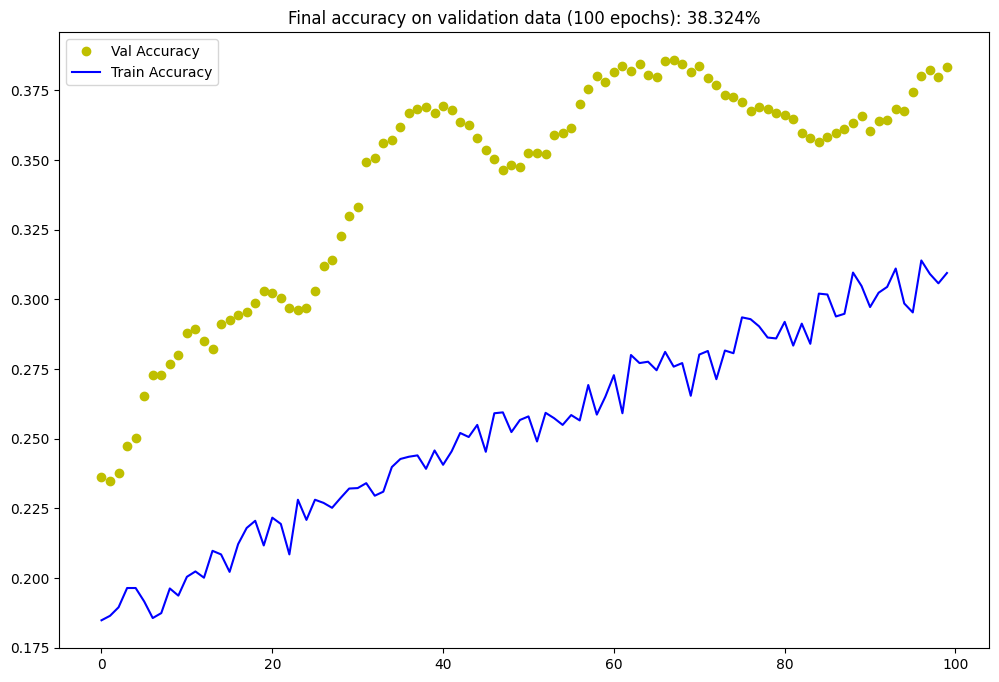

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
plt.plot(hist.history['val_accuracy'], 'yo', label='Val Accuracy')
plt.plot(hist.history['accuracy'], 'b-', label='Train Accuracy')
plt.title("Final accuracy on validation data (100 epochs): {:.3%}".format(hist.history['val_accuracy'][-1:][0]))
plt.legend(loc=2)
_ = plt.show()

100 Epochs is not good enough. We need many more epochs.

#### Checkpoint callback usage
Create a tf.keras.callbacks.ModelCheckpoint callback that saves weights only during training:

In [17]:
checkpoint_path = "training_1/cp.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

### Train the model with new callback

In [18]:
epochs = 1200
hist = model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose,
                 validation_data=(X_test, y_test_hot),
                callbacks=[cp_callback])

Epoch 1/1200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.3207 - loss: 1.6805 - val_accuracy: 0.3858 - val_loss: 1.6477
Epoch 2/1200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3141 - loss: 1.6748 - val_accuracy: 0.3868 - val_loss: 1.6453
Epoch 3/1200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3174 - loss: 1.6983 - val_accuracy: 0.3887 - val_loss: 1.6446
Epoch 4/1200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3146 - loss: 1.6833 - val_accuracy: 0.3868 - val_loss: 1.6428
Epoch 5/1200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3173 - loss: 1.6947 - val_accuracy: 0.3885 - val_loss: 1.6425
Epoch 6/1200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3219 - loss: 1.6783 - val_accuracy: 0.3901 - val_loss: 1.6378
Epoch 7/1200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3119 - loss: 1.6888 - val_accuracy: 0.3913 - val_loss: 1.6336
Epoch 8/1200
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3251 - loss: 1.6880 - val_accuracy: 0.

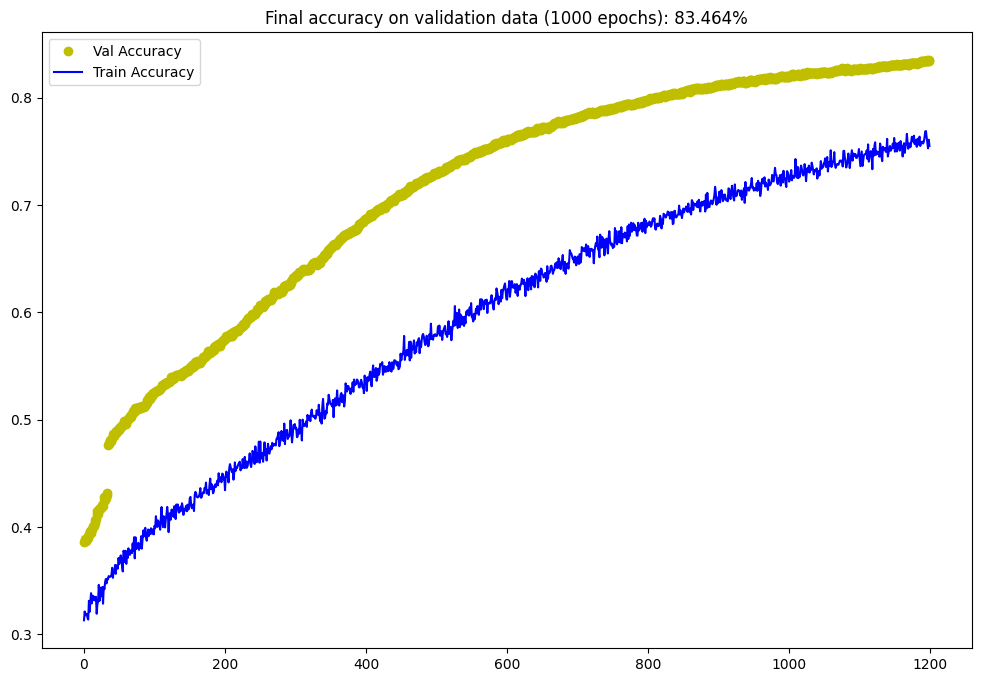

In [19]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['val_accuracy'], 'yo', label='Val Accuracy')
plt.plot(hist.history['accuracy'], 'b-', label='Train Accuracy')
plt.title("Final accuracy on validation data (1000 epochs): {:.3%}".format(hist.history['val_accuracy'][-1:][0]))
plt.legend(loc=2)
_ = plt.show()

### Make Prediction
Let us see whether trained network could properly classify sounds for bed, cat, happy. Test with recorded sounds in the test data set.

In [21]:
# `bed` with southern accent
# saved vectors bed, cat, happy
#'/happy/0685264e_nohash_0.wav
# 'd486fb84_nohash_0.wav, happy d486fb84_nohash_1.wav
# cat 6ac35824_nohash_0.wav, 6ac35824_nohash_1.wav
train_audio_path = '/content/data/'
filename = 'bed/004ae714_nohash_1.wav'
new_sample_rate = 16000
samples, sample_rate = librosa.load(str(train_audio_path) + filename)
ipd.Audio(samples, rate=sample_rate)

In [28]:
print(predict('/content/data/bed/004ae714_nohash_1.wav', model=model))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
eight


In [29]:
train_audio_path = '/content/data/'
filename = 'cat/6ac35824_nohash_0.wav'
new_sample_rate = 16000
samples,sample_rate = librosa.load(str(train_audio_path) + filename)
ipd.Audio(samples, rate=sample_rate)

In [30]:
print(predict('/content/data/cat/6ac35824_nohash_0.wav', model=model))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
dog


In [31]:
train_audio_path = '/content/data/'
filename = 'seven/0b77ee66_nohash_1.wav'
new_sample_rate = 16000
samples, sample_rate = librosa.load(str(train_audio_path) + filename)
ipd.Audio(samples, rate=sample_rate)

In [33]:
print(predict('/content/data/seven/0b77ee66_nohash_1.wav', model=model))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
dog


In [34]:
train_audio_path = '/content/data/'
filename = 'seven/b1114e4f_nohash_0.wav'
new_sample_rate = 16000
samples, sample_rate = librosa.load(str(train_audio_path) + filename)
ipd.Audio(samples, rate=sample_rate)

In [35]:
print(predict('/content/data/seven/b1114e4f_nohash_0.wav', model=model))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
dog


Some predictions are good and some not so good.